In [1]:
import torch

from reggae.utilities import save, load

from reggae.gp.variational.models import NonLinearLFM, ExponentialLFM
from reggae.gp.variational.trainer import TranscriptionalTrainer
from reggae.data_loaders import HafnerData
from reggae.plot.variational_plotters import Plotter
from matplotlib import pyplot as plt

import numpy as np

f64 = np.float64

torch.Size([13])


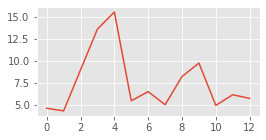

In [2]:
known_target_genes = [
    'CDKN1A', #p21
    'SESN1', #hPA26
    'DDB2',
    'TNFRSF10B',
    'BIK',
]

dataset = HafnerData('../data/', extra_targets=False)
num_genes = len(dataset)
num_tfs = 1
num_times = dataset[0][0].shape[0]

t_inducing = torch.linspace(0, 1, num_times, dtype=torch.float64).reshape((-1, 1))
t_observed = torch.linspace(0, 1, num_times).view(-1)
t_predict = torch.linspace(f64(0), f64(1), 80, dtype=torch.float64)

m_observed = torch.stack([
    dataset[i][1] for i in range(num_genes)
])

plt.figure(figsize=(4, 2))
plt.plot(dataset[0][1])

In [3]:
model = NonLinearLFM(num_genes, num_tfs, t_inducing, dataset, fixed_variance=None)
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
trainer = TranscriptionalTrainer(model, optimizer, dataset)

torch.Size([13]) torch.Size([22, 13])


C:\Users\Jacob\Documents\proj\reggae\reggae\gp\variational\models\model.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inducing_inputs = Parameter(torch.tensor(t_inducing), requires_grad=learn_inducing)


### Outputs prior to training:

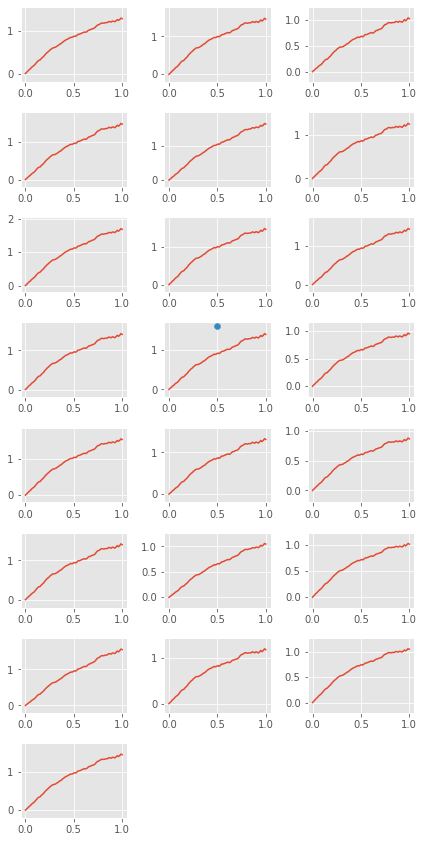

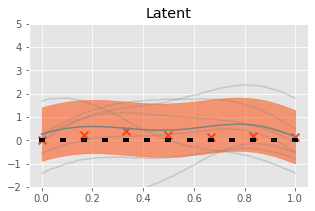

In [4]:
rtol = 1e-3
atol = rtol/10

model_kwargs = {
    'rtol': rtol, 'atol': atol,
    'num_samples': 1
}

plotter = Plotter(model, np.array(dataset.gene_names))
plotter.plot_outputs(t_predict, t_scatter=t_observed,y_scatter=m_observed, model_kwargs=model_kwargs)
plotter.plot_latents(t_predict, ylim=(-2, 5), plot_barenco=True, plot_inducing=False)

In [ ]:
tol = 1e-2
# trainer = Trainer(optimizer)
output = trainer.train(40, rtol=tol, atol=tol/10, report_interval=1, plot_interval=2, num_samples=3)

Epoch 1/40 - Loss: 21716.40 (21716.40 0.00) λ: 0.167 b: 1.12 d 1.44 s: 1.87
Epoch 2/40 - Loss: 16445.05 (15512.33 932.72) λ: 0.156 b: 1.31 d 1.27 s: 2.04
Epoch 3/40 - Loss: 16884.26 (15091.64 1792.62) λ: 0.137 b: 1.48 d 1.10 s: 2.17
Epoch 4/40 - Loss: 13952.02 (12521.61 1430.41) λ: 0.118 b: 1.63 d 1.02 s: 2.18
Epoch 5/40 - Loss: 12830.06 (12013.96 816.10) λ: 0.106 b: 1.78 d 0.91 s: 2.22
Epoch 6/40 - Loss: 12767.09 (11701.26 1065.83) λ: 0.098 b: 1.92 d 0.80 s: 2.25
Epoch 7/40 - Loss: 11887.34 (10698.13 1189.21) λ: 0.091 b: 2.06 d 0.69 s: 2.29
Epoch 8/40 - Loss: 10413.79 (9356.40 1057.40) λ: 0.084 b: 2.17 d 0.61 s: 2.31
Epoch 9/40 - Loss: 10424.49 (9342.04 1082.46) λ: 0.077 b: 2.30 d 0.50 s: 2.34
Epoch 10/40 - Loss: 8008.90 (7170.72 838.18) λ: 0.071 b: 2.39 d 0.44 s: 2.35
Epoch 11/40 - Loss: 6886.74 (6194.41 692.34) λ: 0.065 b: 2.41 d 0.48 s: 2.32
Epoch 12/40 - Loss: 6003.26 (5407.22 596.04) λ: 0.061 b: 2.47 d 0.46 s: 2.33
Epoch 13/40 - Loss: 8669.85 (8230.13 439.72) λ: 0.056 b: 2.58 d 0

### Outputs after training

In [ ]:
tol = 1e-3
plotter.plot_losses(trainer, last_x=100)
plot_genes(rtol=tol, atol=tol/10)
plotter.plot_tfs(ylim=(-2, 9))


In [ ]:
save(model, 'nonlinear')

In [ ]:
do_load = False
if do_load:
    model = load('nonlinear', NonLinearLFM, num_genes, num_tfs,
                 t_inducing, dataset, extra_points=2, fixed_variance=dataset.variance)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    trainer = TranscriptionalTrainer(model, optimizer, dataset)